In [1]:

using MagneticLaplacianSparsifier
using Graphs, MetaGraphs, Random, IterTools, LinearAlgebra, GraphPlot, Arpack, Plots, SparseArrays
using Statistics
using Measures
using StatsBase

In [16]:
rng = Random.default_rng();

weighted = true
singular = true

n = 50
p = 0.9
eta = 0.1

batch = Int(floor(n))
n_batch = 6
n_rep = 10

type = "ERO"
#type = "MUN" 


# planted ranking
exact_ranking = randperm(n)

if type=="MUN"
    meta_g = gen_graph_mun(rng, n, p, eta;exact_ranking)
elseif type=="ERO"
    meta_g = gen_graph_ero(rng, n, p, eta;exact_ranking)
end

m = ne(meta_g)

q = 0
B = magnetic_incidence(meta_g)
lev = leverage_score(B, q)
L = B * B'
normalize_Lap!(L)
normalize_meta_g!(meta_g)

v = least_eigenvector(L;singular)

ranking_full = syncrank(L,meta_g;singular)
tau_full = corkendall(exact_ranking, ranking_full)


0.16244897959183674

## distance between least eigenvectors

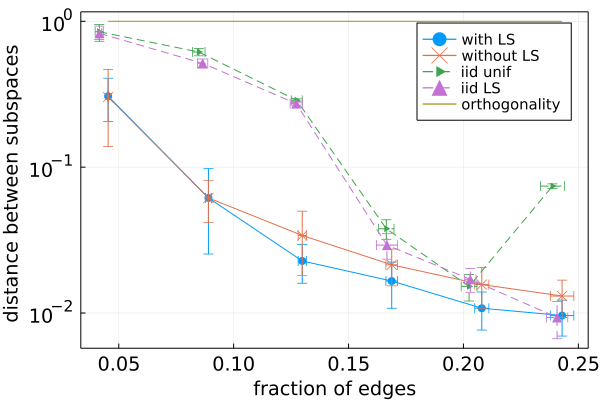

In [20]:
rangebatch = 1:n_batch

err_av = zeros(size(rangebatch))
err_av_lev = zeros(size(rangebatch))
err_av_iid_unif = zeros(size(rangebatch))
err_av_iid_lev = zeros(size(rangebatch))

err_av_std = zeros(size(rangebatch))
err_av_lev_std = zeros(size(rangebatch))
err_av_iid_unif_std = zeros(size(rangebatch))
err_av_iid_lev_std = zeros(size(rangebatch))

tau_av_lev = zeros(size(rangebatch))
tau_av = zeros(size(rangebatch))
tau_av_iid_unif = zeros(size(rangebatch))
tau_av_iid_lev = zeros(size(rangebatch))

tau_av_lev_std = zeros(size(rangebatch))
tau_av_std = zeros(size(rangebatch))
tau_av_iid_unif_std = zeros(size(rangebatch))
tau_av_iid_lev_std = zeros(size(rangebatch))

percent_edges = zeros(size(rangebatch))
percent_edges_std = zeros(size(rangebatch))

percent_edges_unif = zeros(size(rangebatch))
percent_edges_lev = zeros(size(rangebatch))

percent_edges_unif_std = zeros(size(rangebatch))
percent_edges_lev_std = zeros(size(rangebatch))

for i = 1:length(rangebatch)

    err_av_tp = zeros(n_rep,1)
    err_av_lev_tp = zeros(n_rep,1)
    err_av_iid_unif_tp = zeros(n_rep,1)
    err_av_iid_lev_tp = zeros(n_rep,1)

    tau_av_lev_tp = zeros(n_rep,1)
    tau_av_tp = zeros(n_rep,1)
    tau_av_iid_unif_tp = zeros(n_rep,1)
    tau_av_iid_lev_tp = zeros(n_rep,1)

    percent_edges_tp = zeros(n_rep,1)
    percent_edges_unif_tp = zeros(n_rep,1)
    percent_edges_lev_tp = zeros(n_rep,1)

    t = rangebatch[i]

    for j = 1:n_rep

        # heursitic weighting
        avgL_heur = average_sparsifier(rng, meta_g, nothing, q, t;weighted)
        v_av_heur = least_eigenvector(avgL_heur;singular)
        err_av_tp[j] = eigenvec_dist(v,v_av_heur)

        ranking = syncrank(avgL_heur,meta_g;singular)
        tau_av_tp[j] = corkendall(exact_ranking, ranking)

        percent_edges_tp[j] = nb_of_edges(avgL_heur)/m;

        # leverage score weighting
        avgL_lev = average_sparsifier(rng, meta_g, lev, q, t;weighted)
        v_av_lev = least_eigenvector(avgL_lev;singular)
        err_av_lev_tp[j] = eigenvec_dist(v,v_av_lev)

        ranking_lev = syncrank(avgL_lev,meta_g;singular)
        tau_av_lev_tp[j] = corkendall(exact_ranking, ranking_lev)

        # iid unif
        avgL_iid_unif = average_sparsifier_iid(rng, meta_g, nothing, batch, t;weighted)
        v_av_iid_unif = least_eigenvector(avgL_iid_unif;singular)
        err_av_iid_unif_tp[j] = eigenvec_dist(v,v_av_iid_unif)

        ranking_iid_unif = syncrank(avgL_iid_unif,meta_g;singular)
        tau_av_iid_unif_tp[j] = corkendall(exact_ranking, ranking_iid_unif)

        percent_edges_unif_tp[j] = nb_of_edges(avgL_iid_unif)/m

        # iid lev
        avgL_iid_lev = average_sparsifier_iid(rng, meta_g, lev, batch, t;weighted)
        v_av_iid_lev = least_eigenvector(avgL_iid_lev;singular)
        err_av_iid_lev_tp[j] = eigenvec_dist(v,v_av_iid_lev)

        ranking_iid_lev = syncrank(avgL_iid_lev,meta_g;singular)
        tau_av_iid_lev_tp[j] = corkendall(exact_ranking, ranking_iid_lev)

        percent_edges_lev_tp[j] = nb_of_edges(avgL_iid_lev)/m

    end
    err_av[i] = mean(err_av_tp)
    err_av_lev[i] = mean(err_av_lev_tp)
    err_av_iid_unif[i] = mean(err_av_iid_unif_tp)
    err_av_iid_lev[i] = mean(err_av_iid_lev_tp)

    err_av_std[i] = std(err_av_tp)
    err_av_lev_std[i] = std(err_av_lev_tp)
    err_av_iid_unif_std[i] = std(err_av_lev_tp)
    err_av_iid_lev_std[i] = std(err_av_lev_tp)

    tau_av[i] = mean(tau_av_tp)
    tau_av_lev[i] = mean(tau_av_lev_tp)
    tau_av_iid_unif[i] = mean(tau_av_iid_unif_tp)
    tau_av_iid_lev[i] = mean(tau_av_iid_lev_tp)

    tau_av_std[i] = std(tau_av_tp)
    tau_av_lev_std[i] = std(tau_av_lev_tp)
    tau_av_iid_unif_std[i] = std(tau_av_iid_unif_tp)
    tau_av_iid_lev_std[i] = std(tau_av_iid_lev_tp)
    
    percent_edges[i] = mean(percent_edges_tp)
    percent_edges_std[i] = std(percent_edges_tp)

    percent_edges_unif[i] = mean(percent_edges_unif_tp)
    percent_edges_unif_std[i] = std(percent_edges_unif_tp)

    percent_edges_lev[i] = mean(percent_edges_lev_tp)
    percent_edges_lev_std[i] = std(percent_edges_lev_tp)

end

plot(percent_edges,err_av_lev,xerror=percent_edges_std,yerror=err_av_lev_std, yaxis=:log,labels = "with LS",xlabel = "fraction of edges",ylabel = "distance between subspaces ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,err_av,xerror=percent_edges_std,yerror=err_av_std, yaxis=:log,labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,err_av_iid_unif,yerror=err_av_iid_unif_std, yaxis=:log,labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,err_av_iid_lev,yerror=err_av_iid_lev_std, yaxis=:log,labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,ones(size(rangebatch)),labels = "orthogonality",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box, yticks=[1e-3,1e-2,1e-1, 1e0])

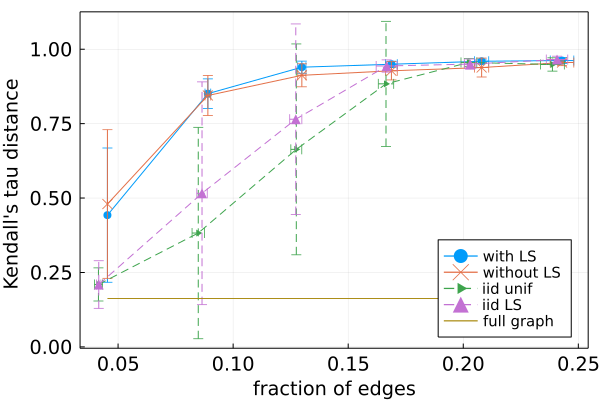

In [21]:
plot(percent_edges,xerror=percent_edges_std,tau_av_lev,yerror=tau_av_lev_std,labels = "with LS",xlabel = "fraction of edges",ylabel = "Kendall's tau distance ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,xerror=percent_edges_std,tau_av,yerror=tau_av_std, labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,tau_av_iid_unif,yerror=tau_av_iid_unif_std, labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,tau_av_iid_lev,yerror=tau_av_iid_lev_std, labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,tau_full*ones(size(rangebatch)),labels = "full graph",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,legend=:bottomright)

In [22]:

plot(percent_edges,err_av_lev,xerror=percent_edges_std,yerror=err_av_lev_std, yaxis=:log,labels = "with LS",xlabel = "fraction of edges",ylabel = "distance between subspaces ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,err_av,xerror=percent_edges_std,yerror=err_av_std, yaxis=:log,labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,err_av_iid_unif,yerror=err_av_iid_unif_std, yaxis=:log,labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,err_av_iid_lev,yerror=err_av_iid_lev_std, yaxis=:log,labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,ones(size(rangebatch)),labels = "orthogonality",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box, yticks=[1e-3,1e-2,1e-1, 1e0])

foldername = "figures/"
name = type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"EigenDistance_norm.pdf"
savefig(foldername*name)

In [ ]:
plot(percent_edges,xerror=percent_edges_std,tau_av_lev,yerror=tau_av_lev_std,labels = "with LS",xlabel = "fraction of edges",ylabel = "Kendall's tau distance ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,xerror=percent_edges_std,tau_av,yerror=tau_av_std, labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,tau_av_iid_unif,yerror=tau_av_iid_unif_std, labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,tau_av_iid_lev,yerror=tau_av_iid_lev_std, labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,tau_full*ones(size(rangebatch)),labels = "full graph",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,legend=:bottomright)
#yaxis!(:log)
foldername = "figures/"
name = type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"Kendall_norm.pdf"
savefig(foldername*name)

## syncrank


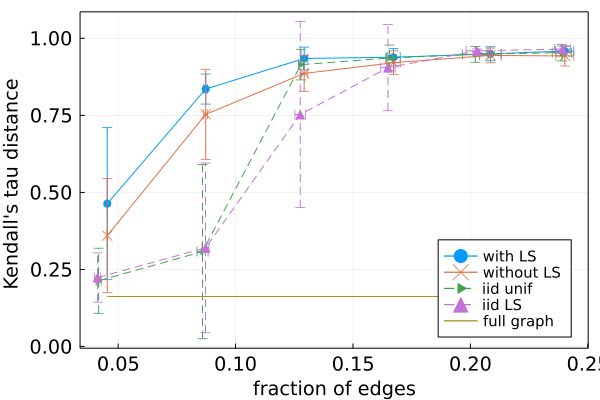

In [18]:
tau_av_lev = zeros(size(rangebatch))
tau_av = zeros(size(rangebatch))
tau_av_iid_unif = zeros(size(rangebatch))
tau_av_iid_lev = zeros(size(rangebatch))


percent_edges = zeros(size(rangebatch))
percent_edges_unif = zeros(size(rangebatch))
percent_edges_lev = zeros(size(rangebatch))

tau_av_lev_std = zeros(size(rangebatch))
tau_av_std = zeros(size(rangebatch))
tau_av_iid_unif_std = zeros(size(rangebatch))
tau_av_iid_lev_std = zeros(size(rangebatch))


percent_edges_std = zeros(size(rangebatch))
percent_edges_unif_std = zeros(size(rangebatch))
percent_edges_lev_std = zeros(size(rangebatch))


for i = 1:length(rangebatch)

    tau_av_lev_tp = zeros(n_rep,1)
    tau_av_tp = zeros(n_rep,1)
    tau_av_iid_unif_tp = zeros(n_rep,1)
    tau_av_iid_lev_tp = zeros(n_rep,1)

    percent_edges_tp = zeros(n_rep,1)
    percent_edges_unif_tp = zeros(n_rep,1)
    percent_edges_lev_tp = zeros(n_rep,1)
    
    t = rangebatch[i]

    for j = 1:n_rep

        # heursitic weighting
        avgL = average_sparsifier(rng, meta_g, nothing, q, t;weighted)
        percent_edges_tp[j] = nb_of_edges(avgL)/m;
        ranking = syncrank(avgL,meta_g;singular)
        tau_av_tp[j] = corkendall(exact_ranking, ranking)

        # leverage score weighting
        avgL_lev = average_sparsifier(rng, meta_g, lev, q, t;weighted)
        ranking_lev = syncrank(avgL_lev,meta_g;singular)
        tau_av_lev_tp[j] = corkendall(exact_ranking, ranking_lev)

        # iid unif
        avgL_iid_unif = average_sparsifier_iid(rng, meta_g, nothing, batch, t;weighted)
        percent_edges_unif_tp[j] = nb_of_edges(avgL_iid_unif)/m
        ranking_iid_unif = syncrank(avgL_iid_unif,meta_g;singular)
        tau_av_iid_unif_tp[j] = corkendall(exact_ranking, ranking_iid_unif)

        # iid lev
        avgL_iid_lev = average_sparsifier_iid(rng, meta_g, lev, batch, t;weighted)
        percent_edges_lev_tp[j] = nb_of_edges(avgL_iid_lev)/m
        ranking_iid_lev = syncrank(avgL_iid_lev,meta_g;singular)
        tau_av_iid_lev_tp[j] = corkendall(exact_ranking, ranking_iid_lev)

    end
    tau_av[i] = mean(tau_av_tp)
    tau_av_lev[i] = mean(tau_av_lev_tp)
    tau_av_iid_unif[i] = mean(tau_av_iid_unif_tp)
    tau_av_iid_lev[i] = mean(tau_av_iid_lev_tp)

    percent_edges[i] = mean(percent_edges_tp)
    percent_edges_std[i] = std(percent_edges_tp)

    percent_edges_unif[i] = mean(percent_edges_unif_tp)
    percent_edges_unif_std[i] = std(percent_edges_unif_tp)

    percent_edges_lev[i] = mean(percent_edges_lev_tp)
    percent_edges_lev_std[i] = std(percent_edges_lev_tp)

    tau_av_std[i] = std(tau_av_tp)
    tau_av_lev_std[i] = std(tau_av_lev_tp)
    tau_av_iid_unif_std[i] = std(tau_av_iid_unif_tp)
    tau_av_iid_lev_std[i] = std(tau_av_iid_lev_tp)

end


plot(percent_edges,xerror=percent_edges_std,tau_av_lev,yerror=tau_av_lev_std,labels = "with LS",xlabel = "fraction of edges",ylabel = "Kendall's tau distance ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,xerror=percent_edges_std,tau_av,yerror=tau_av_std, labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,tau_av_iid_unif,yerror=tau_av_iid_unif_std, labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,tau_av_iid_lev,yerror=tau_av_iid_lev_std, labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,tau_full*ones(size(rangebatch)),labels = "full graph",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,legend=:bottomright)

In [24]:
plot(percent_edges,xerror=percent_edges_std,tau_av_lev,yerror=tau_av_lev_std,labels = "with LS",xlabel = "fraction of edges",ylabel = "Kendall's tau distance ",markerstrokecolor=:auto,markershape=:circle,markersize = 5)

plot!(percent_edges,xerror=percent_edges_std,tau_av,yerror=tau_av_std, labels = "without LS",markerstrokecolor=:auto,markershape=:xcross,markersize = 5)

plot!(percent_edges_unif,xerror=percent_edges_unif_std,tau_av_iid_unif,yerror=tau_av_iid_unif_std, labels = "iid unif",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:rtriangle)

plot!(percent_edges_lev,xerror=percent_edges_lev_std,tau_av_iid_lev,yerror=tau_av_iid_lev_std, labels = "iid LS",markerstrokecolor=:auto,markersize = 5,linestyle=:dash,markershape=:utriangle)

plot!(percent_edges,tau_full*ones(size(rangebatch)),labels = "full graph",xtickfontsize=13,ytickfontsize=13,xguidefontsize=13,yguidefontsize=13,legendfontsize=10, framestyle = :box,legend=:bottomright)
#yaxis!(:log)
foldername = "figures/"
name = type*"n"*string(n)*"p"*string(p)*"eta"*string(eta)*"Kendall_norm.pdf"
savefig(foldername*name)